# Data exploration notebook

Importing required libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time
%matplotlib inline
sns.set(rc={"figure.figsize": (18, 10)});

Loading datasets.

In [3]:
properties = pd.read_csv("data/properties_2016.csv", low_memory=False)
train = pd.read_csv("data/train_2016_v2.csv")
train['transactiondate'] = pd.to_datetime(train['transactiondate'], format="%Y-%m-%d")

Merging both dataset into a single DataFrame and printing some data.

In [4]:
merged = pd.merge(train, properties, on=["parcelid"])
merged['transaction_month'] = merged['transactiondate'].dt.month

print(merged.shape)
display(merged.head())

(90275, 61)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,transaction_month
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13,1
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN,1
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13,1
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13,1
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13,1


Printing the number of transactions per month.

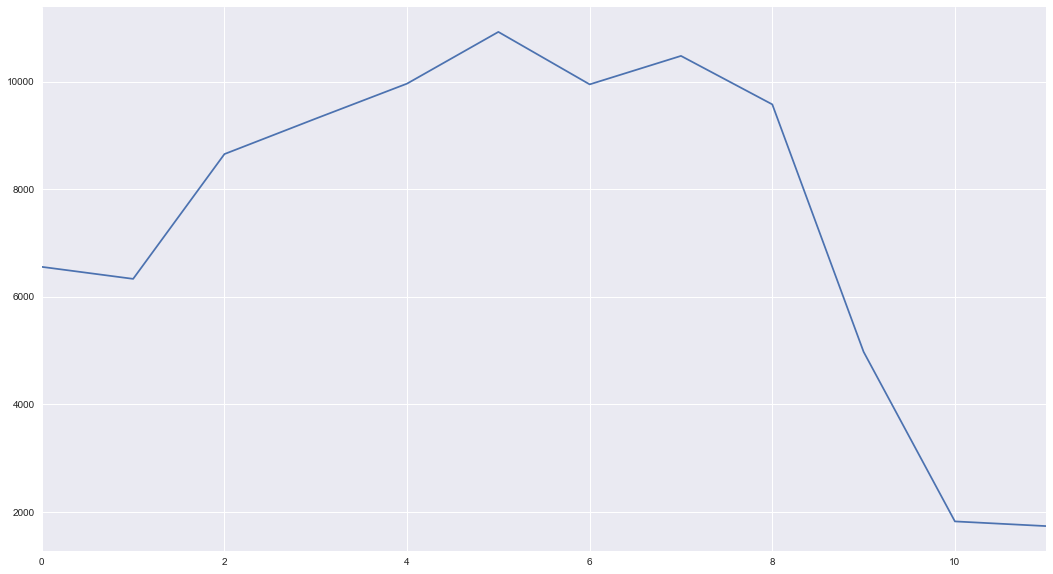

In [5]:
sns.tsplot(data=train.groupby(train['transactiondate'].dt.month).count()['parcelid'])

Printing the average logerror per month

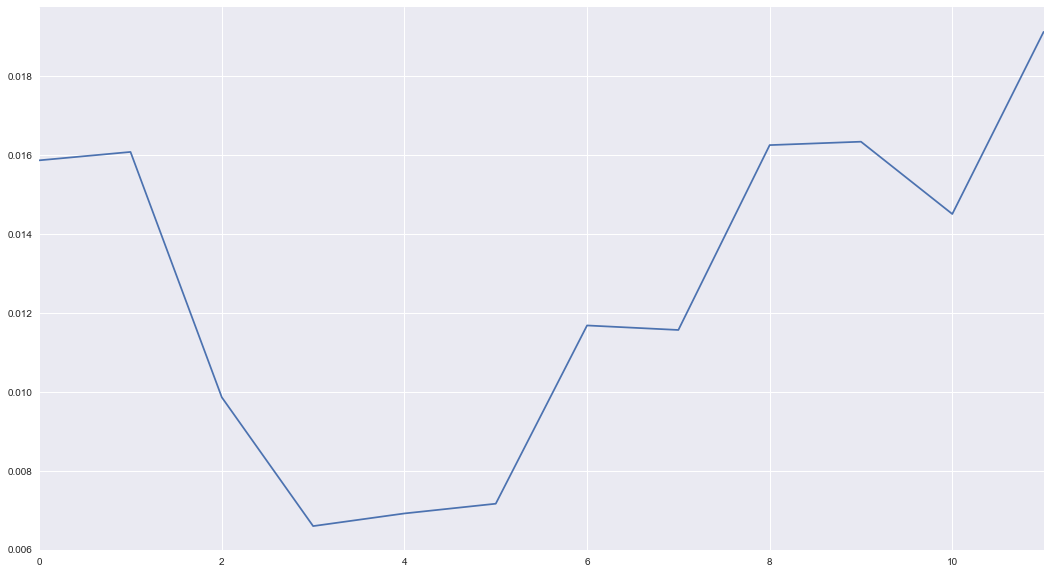

In [6]:
sns.tsplot(data=train.groupby(train['transactiondate'].dt.month).mean()["logerror"])

Plot of logerror distribution.

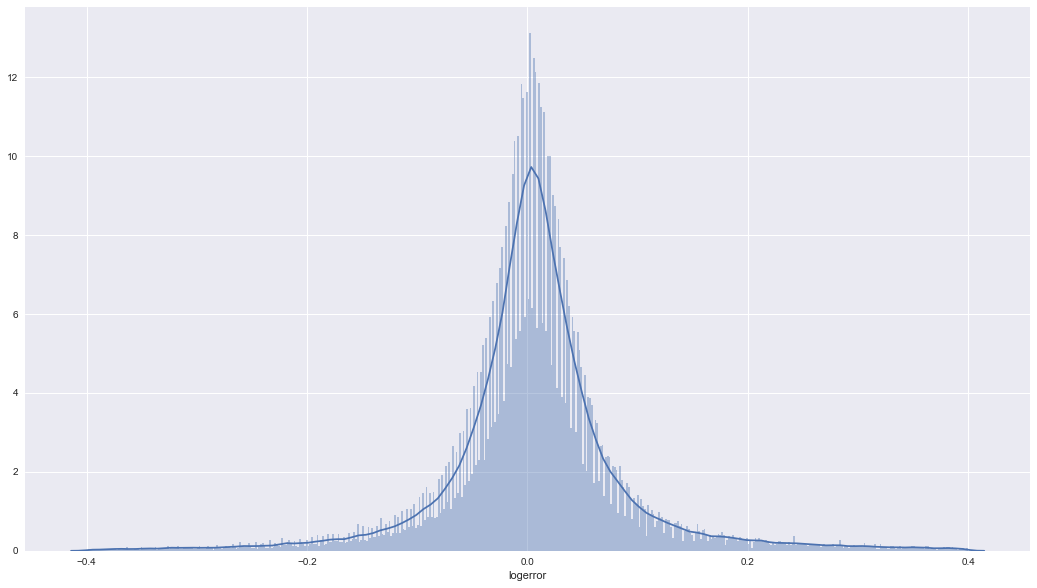

In [7]:
logerror = train['logerror']
sns.distplot(logerror[logerror<.4][logerror>-.4], bins=500)

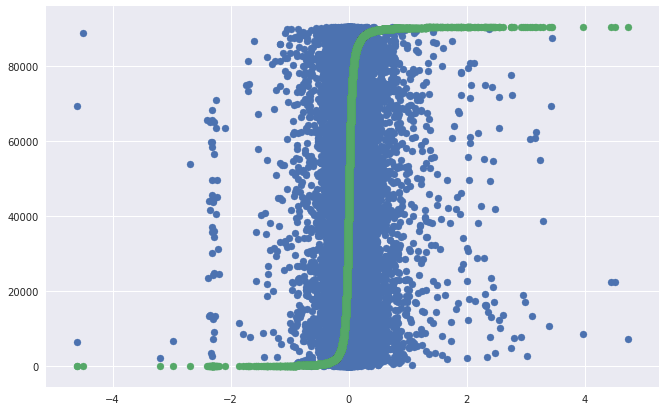

In [8]:
plt.figure(figsize=(11,7))
plt.scatter(logerror, logerror.index)
plt.scatter(logerror.sort_values(), logerror.index)

Number of missing values per feature.

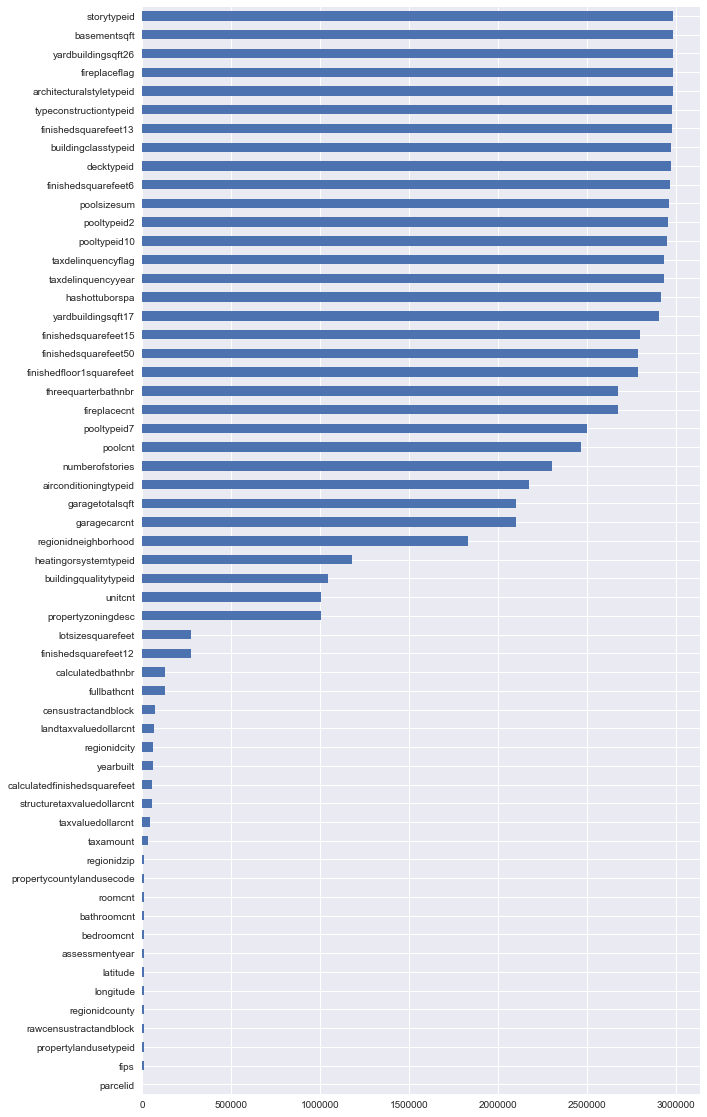

In [8]:
nan_data_count = properties.isnull().sum().sort_values()
nan_data_count.plot.barh(figsize=(10,20))

Correlation matrix.

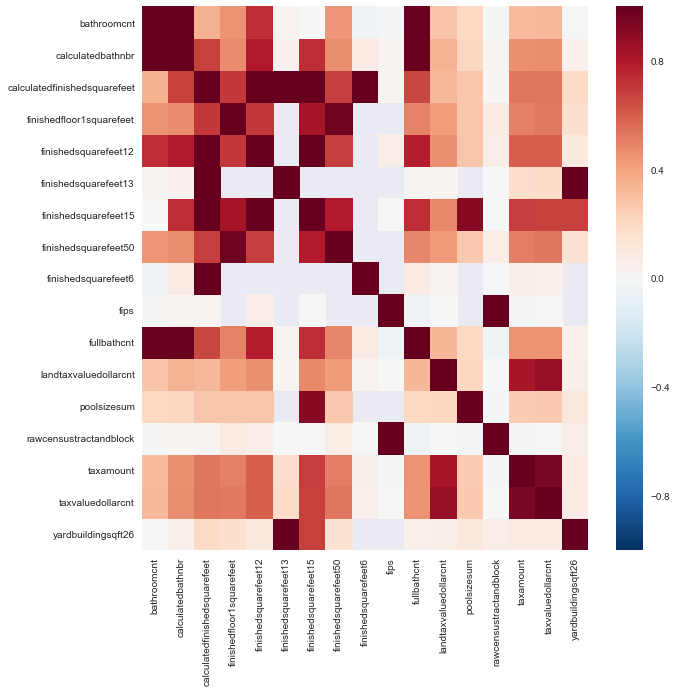

In [9]:
corrmat = properties.corr()
indices = np.where(corrmat > 0.85)
indices = [(corrmat.index[x], corrmat.columns[y]) for x, y in zip(*indices) if x != y and x < y]
indices = np.unique(indices).tolist()
corrmat = properties[indices].corr()
sns.set(rc={"figure.figsize": (10, 10)});
sns.heatmap(data=corrmat)

Geographical distribution.

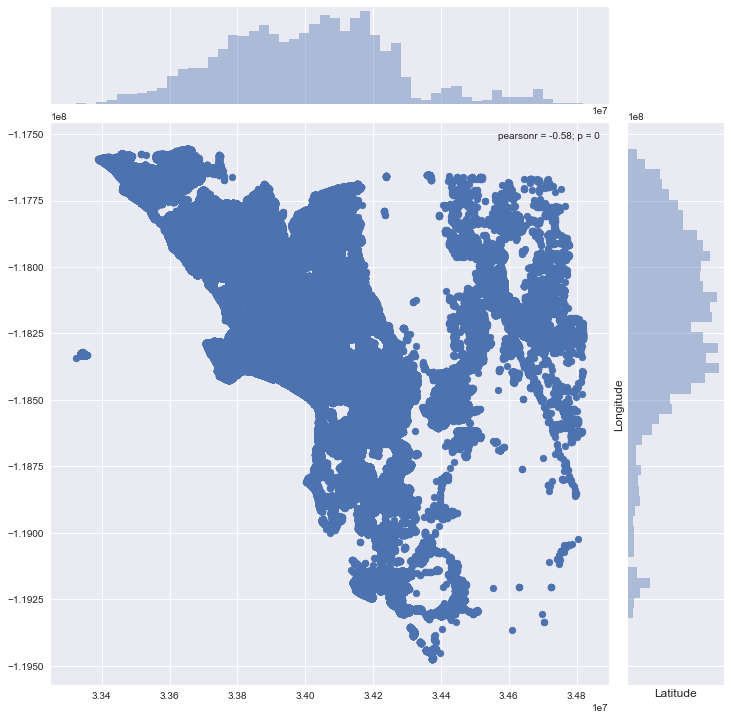

In [11]:
plt.figure(figsize=(12,12))
sns.jointplot(x=properties.latitude.values, y=properties.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

Data preprocessing for feature relevance analisys.

In [12]:
def transactiondate_parser(str_date):
    date_pattern = "%Y-%m-%d"
    date_2016_begin = 1451617200.0
    date_2017_end = 1514689200.0
    epoch = time.mktime(time.strptime(str_date, date_pattern))
    return (epoch - date_2016_begin) / (date_2017_end - date_2016_begin)


def categorical_parsing(prop, train):
    strcols = prop.select_dtypes([object]).columns.values.tolist()

    for i in tqdm(strcols):
        prop[i] = prop[i].apply(lambda x: str(x))
        encoder = LabelEncoder()
        encoder.fit(prop[i])
        prop[i] = encoder.transform(prop[i])

    merged = pd.merge(train, prop, on=["parcelid"])
#    merged["transactiondate"] = merged["transactiondate"].apply(transactiondate_parser)
    return merged


In this cell, the feature relevance is performed.

100%|██████████| 5/5 [00:37<00:00,  7.65s/it]


[53 49 50 52 25 23 10 24 46 11 38 56  4 34 37 33 35  6 31  3  0 18  7 32 22
 20 39 19 13 47 17 43 44 26 41 55 30  9 14 15 21 36 16 54 28  8  5 29 45  2
 27 42  1 40 48 12 51]


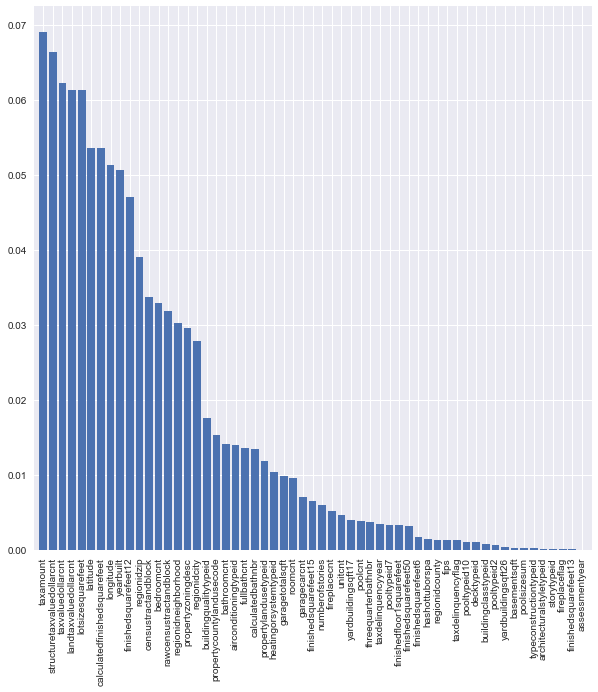

In [13]:
cat_ = ['parcelid', 'logerror', 'transactiondate']
merged = categorical_parsing(properties, train)
feat_names = merged.drop(cat_, axis=1).columns

X = merged.drop(cat_, axis=1).fillna(0).values
y = merged['logerror'].values


from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=250, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(X, y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print(indices)


plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Updating the relevance feature into a percentage.

In [14]:
m = np.max(importances)
for i in range(len(importances)):
    importances[i] = (importances[i]/m)

The same feature relevance plot, but using percentage.

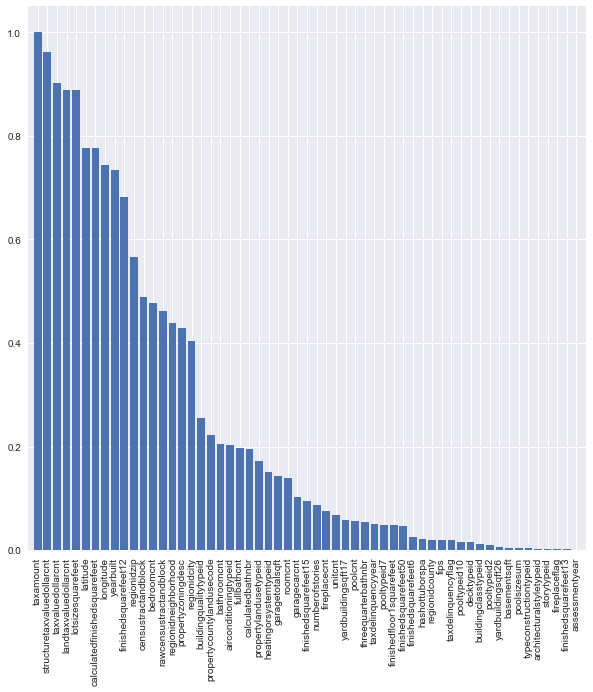

In [16]:
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()